In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
print(ls.main_path)

/Users/elenag/Desktop/PlotterLEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 03302021


In [5]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
from scipy import linalg

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [6]:
def solveForXS(Flux_nu_FHC,Flux_nu_RHC,Flux_antinu_FHC,Flux_antinu_RHC,Rate_FHC,Rate_RHC):
    a = np.array([[Flux_nu_FHC, Flux_nu_RHC], [Flux_antinu_FHC, Flux_antinu_RHC]])
    b = np.array([Rate_FHC, Rate_RHC])
    x = linalg.solve(a, b)
    print(x)


In [7]:
def importFlux():
    fhcFile = "/Users/elenag/Desktop/PlotterLEE/NuMIFlux/NuMIFluxBeamVar/BeamlineGeometryVariations/FHC/output_uboone_fhc_run0_merged.root"
    rhcFile = "/Users/elenag/Desktop/PlotterLEE/NuMIFlux/NuMIFluxBeamVar/BeamlineGeometryVariations/RHC/output_uboone_rhc_run0_merged.root"
    fhcHistoNue     = uproot.open(fhcFile)['nue/Detsmear/nue_CV_AV_TPC_5MeV_bin']
    rhcHistoNue     = uproot.open(rhcFile)['nue/Detsmear/nue_CV_AV_TPC_5MeV_bin']
    fhcHistoNueBar  = uproot.open(fhcFile)['nuebar/Detsmear/nuebar_CV_AV_TPC_5MeV_bin']
    rhcHistoNueBar  = uproot.open(rhcFile)['nuebar/Detsmear/nuebar_CV_AV_TPC_5MeV_bin']
    print(rhcHistoNue.bins[len(rhcHistoNue.bins)-1], rhcHistoNueBar.bins[len(rhcHistoNue.bins)-1])
    #print(fhcHistoNue.bins, fhcHistoNueBar.bins)

importFlux()

[19.995 20.   ] [19.995 20.   ]


In [8]:
#####################################################################################
############################### MC as if it was data ################################
#####################################################################################
tree = "NeutrinoSelectionFilter"

NU_R1    = 'test/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
NUE_R1   = '/Users/elenag/Desktop/PlotterLEE/root_files/FullMC/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
NU_R3    = 'run3/neutrinoselection_filt_run3b_overlay'    +ls.APPEND #newTune
NUE_R3   = '/Users/elenag/Desktop/PlotterLEE/root_files/FullMC/neutrinoselection_filt_run3b_overlay_intrinsic'+ls.APPEND #newTune

mc_R1    = uproot.open(ls.ntuple_path+NU_R1 +".root")[ls.fold][tree]
nue_R1   = uproot.open(NUE_R1+".root")[ls.fold][tree]
mc_R3    = uproot.open(ls.ntuple_path+NU_R3 +".root")[ls.fold][tree]
nue_R3   = uproot.open(NUE_R3+".root")[ls.fold][tree]

variables = ["nu_pdg", "slpdg", "trk_score_v", "backtracked_pdg","true_nu_px","true_nu_py","true_nu_pz","category",
             "ccnc", "true_nu_vtx_z","true_nu_vtx_y","true_nu_vtx_x", "run","sub","evt", "nproton", "nu_e",
             "pi0_e","npi0","nslice"]

WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 

WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


    
#make the list unique
variables = list(set(variables))
print(variables)


nue_R1  = nue_R1.pandas.df(variables + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)
mc_R1   = mc_R1.pandas .df(variables + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)
nue_R3  = nue_R3.pandas.df(variables + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)
mc_R3   = mc_R3.pandas .df(variables + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)


['backtracked_pdg', 'nu_e', 'evt', 'nproton', 'pi0_e', 'true_nu_pz', 'npi0', 'true_nu_vtx_y', 'nslice', 'trk_score_v', 'true_nu_vtx_z', 'category', 'true_nu_px', 'ccnc', 'run', 'nu_pdg', 'true_nu_vtx_x', 'slpdg', 'sub', 'true_nu_py']


In [9]:
df_v =  [mc_R1,nue_R1,mc_R3,nue_R3]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 

    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    df[ 'weightSplineTimesPPFX' ]          = df[ 'weightSpline' ]*df['ppfx_cv']
    
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [10]:
#for i,df in enumerate(df_v):
#    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']

In [11]:

#scaleFlat = 1

#for i,df in enumerate(df_v):
#    if scaleFlat == 1:
#        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
#        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
#    elif scaleFlat == 2:
#        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
#        pi0emax = 0.6
#        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
#        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
#    elif scaleFlat == 0:
#        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        


In [12]:
for i,df in enumerate(df_v):
    df.loc[ (df['nu_pdg'] == -12), 'category' ] = 11111
    df.loc[ (df['nu_pdg'] ==  12), 'category' ] = 11110


# Plotting part

In [13]:
import plotter
import importlib
importlib.reload(plotter)


<module 'plotter' from '/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py'>

In [14]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
#nueMC = mc_R1.query("(abs(nu_pdg) == 12 & ccnc == 0)")

nue_R1   = nue_R1.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")
nue_R3   = nue_R1.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")


data =  nue_R1.query("evt == 1802") 
dirt =  nue_R1.query("evt == 1802") 
ext  =  nue_R1.query("evt == 1802") 

samples_R1 = {
    "mc"  : mc_R1,
    "nue" : nue_R1,
    "data": data,
    "dirt": dirt,
    "ext" : ext
}


samples_R3 = {
    "mc"  : mc_R3,
    "nue" : nue_R3,
    "data": data,
    "dirt": dirt,
    "ext" : ext
}


pot_R1       = 2e+20
mcratio_R1   = pot_R1/2.32135e+21 
nueratio_R1  = pot_R1/2.59311e+22 
dirtratio_R1 = pot_R1/1.42143e+21
extratio_R1  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99


pot_R3        = 5.0e20 
mcratio_R3    = pot_R3/1.99076e+21
nueratio_R3   = pot_R3/2.5392e+22 
dirtratio_R3  = pot_R3/1.03226e+21
extratio_R3   = 10363728.0/32878305.25 

print(nueratio_R1, nueratio_R3)

scaling    = 1
SPLIT      = 1.0
scalingEXT = 0.98
scalingDRT = 0.35

weights_R1 = {
            "mc"  : mcratio_R1   * SPLIT * scaling,   
            "nue" : nueratio_R1  * SPLIT * scaling,  
            "ext" : extratio_R1  * SPLIT * scalingEXT, 
            "dirt": dirtratio_R1 * SPLIT * scalingDRT, 
}
my_plotter_R1 = plotter.Plotter(samples_R1, weights_R1, pot=pot_R1)


weights_R3 = {
            "mc"  : mcratio_R3   * SPLIT * scaling,   
            "nue" : nueratio_R3  * SPLIT * scaling,  
            "ext" : extratio_R3  * SPLIT * scalingEXT, 
            "dirt": dirtratio_R3 * SPLIT * scalingDRT, 
}
my_plotter_R3 = plotter.Plotter(samples_R3, weights_R3, pot=pot_R3)


0.007712746470454397 0.01969124133585381


In [18]:
QUERY = 'abs(nu_pdg) == 12'

VARIABLE, BINS, RANGE, XTIT = 'nproton', 8, (0.0,8.), r"n protons"
VARIABLE, BINS, RANGE, XTIT = 'nu_e', 100, (0.0,20.), r"Reconstructed Energy [GeV]"

abs(nu_pdg) == 12& nu_e <= 20 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2161: RuntimeWarning: divide by zero encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


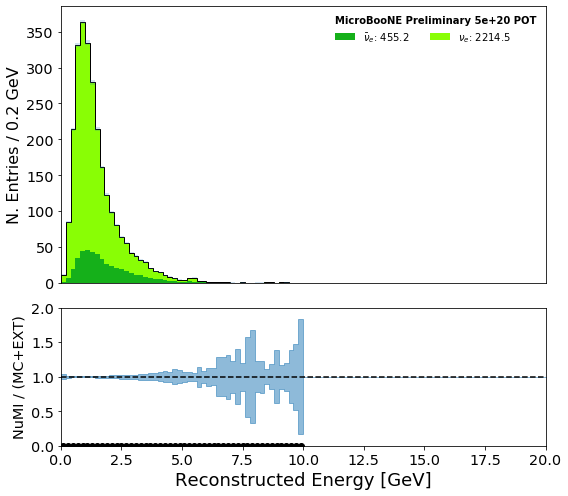

In [16]:
sysBool = False
import matplotlib.pyplot as plt
import matplotlib

fig, ax1, ax2, label, puppa = my_plotter_R3.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    draw_sys=sysBool,
    draw_data=False,
    draw_geoSys = sysBool, 
    stacksort=3,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    title=XTIT,
    bins=BINS,
    range=RANGE #,
)[0:5]


#ax1.scatter(midBin,label[0][1])
midBin = (label[1][1:] + label[1][:-1])/2.
rate_R3 = label[0][1]

abs(nu_pdg) == 12& nu_e <= 20 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2161: RuntimeWarning: divide by zero encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


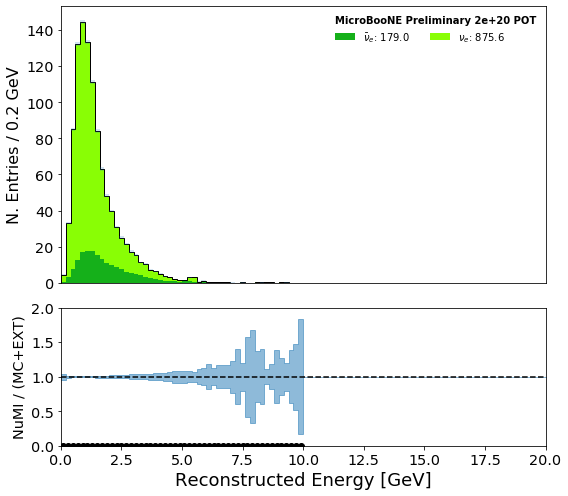

In [17]:
fig, ax1, ax2, label, puppa = my_plotter_R1.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    draw_sys=sysBool,
    draw_data=False,
    draw_geoSys = sysBool, 
    stacksort=3,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    title=XTIT,
    bins=BINS,
    range=RANGE #,
)[0:5]

rate_R1 = label[0][1]

In [ ]:
# Super Spherical Cow
# N Events = Flux [/cm2/sec]* XS [cm2] * Targets
def solveForXS(Flux_nu_FHC,Flux_nu_RHC,Flux_antinu_FHC,Flux_antinu_RHC,Rate_FHC,Rate_RHC):
    a = np.array([[Flux_nu_FHC, Flux_nu_RHC], [Flux_antinu_FHC, Flux_antinu_RHC]])
    b = np.array([Rate_FHC, Rate_RHC])
    from scipy import linalg
    x = linalg.solve(a, b)
    return(x)



In [ ]:
def importFlux():
    fhcFile = "/Users/elenag/Desktop/PlotterLEE/NuMIFlux/NuMIFluxBeamVar/BeamlineGeometryVariations/FHC/output_uboone_fhc_run0_set1.root"
    rhcFile = "/Users/elenag/Desktop/PlotterLEE/NuMIFlux/NuMIFluxBeamVar/BeamlineGeometryVariations/RHC/output_uboone_rhc_run0_set1.root"
    fhcHistoNue     = uproot.open(fhcFile)['nue/Detsmear/nue_CV_AV_TPC_5MeV_bin']
    rhcHistoNue     = uproot.open(rhcFile)['nue/Detsmear/nue_CV_AV_TPC_5MeV_bin']
    fhcHistoNueBar  = uproot.open(fhcFile)['nuebar/Detsmear/nuebar_CV_AV_TPC_5MeV_bin']
    rhcHistoNueBar  = uproot.open(rhcFile)['nuebar/Detsmear/nuebar_CV_AV_TPC_5MeV_bin']
    potRHC_MC = 465.
    potFHC_MC = 491.
    #print(rhcHistoNue.values[0], rhcHistoNueBar.bins[0])
    #ReBin the bins
    v = np.arange(0,4000)
    v = np.hstack([v[::40],v[39::40]])
    v.sort()
    
    # Normalized to MC POT
    valuesRHC_Nue    = (rhcHistoNue.values.reshape((100,40))).sum(axis=1)/potRHC_MC
    valuesRHC_NueBar = (rhcHistoNueBar.values.reshape((100,40))).sum(axis=1)/potRHC_MC
    valuesFHC_Nue    = (fhcHistoNue.values.reshape((100,40))).sum(axis=1)/potFHC_MC
    valuesFHC_NueBar = (fhcHistoNueBar.values.reshape((100,40))).sum(axis=1)/potFHC_MC

    #Same Bins for all histograms
    fluxBins = rhcHistoNue.bins[v,[0,1]*100].reshape((100,2))
    return(fluxBins, valuesFHC_Nue, valuesFHC_NueBar, valuesRHC_Nue, valuesRHC_NueBar)

fluxTuple = importFlux()

In [ ]:
fluxB            = fluxTuple[0]
valuesFHC_Nue    = fluxTuple[1]
valuesFHC_NueBar = fluxTuple[2]
valuesRHC_Nue    = fluxTuple[3]
valuesRHC_NueBar = fluxTuple[4]

print(rate_R1.shape,rate_R3.shape,midBin.shape)
print(fluxB.shape,valuesFHC_Nue.shape,valuesFHC_NueBar.shape)
print(fluxB.shape,valuesRHC_Nue.shape,valuesRHC_NueBar.shape)


for i in range(99):
    if valuesFHC_Nue[i] == 0:
        break
    print(i, solveForXS(valuesFHC_Nue[i],valuesRHC_Nue[i],valuesFHC_NueBar[i],valuesRHC_NueBar[i],rate_R1[i],rate_R3[i]))